## Семинар 6 "Segmentation"

ФИО: __Иванов Иван Иванович__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sys


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images')
t.save(test, TEST_PATH)
train_data = process('training/images', "training/1st_manual/")

In [3]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

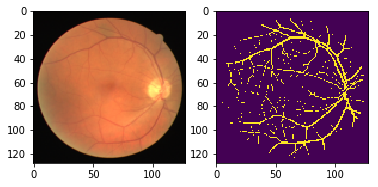

In [4]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [5]:
i = 0
train_X = []
test_X = []
for i in range(0, 20):
    if i < 4:
         test_X.append(dataset[i])
    else:
         train_X.append(dataset[i])

In [6]:
len(train_X)

16

#### Augmentation

#### 1) rotation

In [13]:
import PIL
class DatasetRotated():
    def __init__(self,data,source_transform,target_transform, angle_val):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
        self.to_pil = tsf.ToPILImage()
        self.angle_val = angle_val
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        
        img = self.to_pil(img)
        mask = self.to_pil(mask)
        
        img = tsf.functional.affine(img, angle=self.angle_val, translate=(0, 0), scale=1, shear = False)
        mask = tsf.functional.affine(mask, angle=self.angle_val, translate=(0, 0), scale=1, shear = False)
        
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
   
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)


In [14]:
for angle in range(5, 360, 5):
    dataset_rotated = DatasetRotated(train_data,s_trans,t_trans, angle)
    for i in range(0, 20):
        if i < 4:
             test_X.append(dataset_rotated[i])
        else:
             train_X.append(dataset_rotated[i])

#### train

In [7]:
train_dataloader = DataLoader(train_X, batch_size=4, shuffle=True)

test_dataloader = DataLoader(test_X, batch_size=4)

In [8]:
dtype=t.FloatTensor

def train(network, epochs, learning_rate, loss, optim=t.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample[0]
                X = X.type(dtype)
                y = sample[1]
                
                
                
                prediction = network(X)
             
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                
  
            train_loss_epochs.append(np.mean(losses))
            
            losses = []    
            for sample in test_dataloader:
                X = sample[0]
                X = X.type(dtype)
                y = sample[1]
                
               
                prediction = network(X)
               
                    
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) Dice: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

### U-Net

In [20]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
      #  print(x1.size())
       # print(x2.size())
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
       # print(x4.size())
       # print(x5.size())
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [21]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [22]:
model = UNet(3, 1)

Epoch 19... (Train/Test) Dice: 0.242/0.256

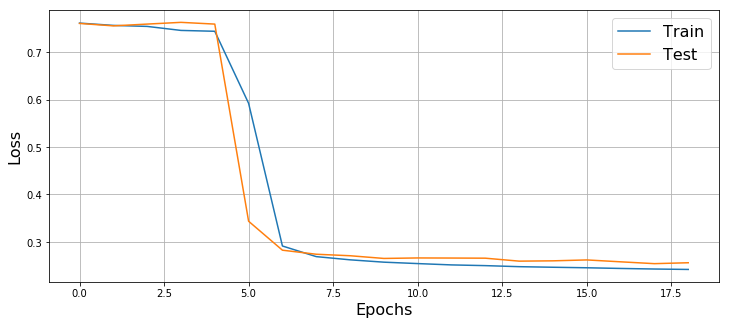

In [23]:
train(model, 20, 0.01, soft_dice_loss)

### ResU-Net

In [ ]:
# sub-parts of the ResU-Net model

from torch import nn
import torch.nn.functional as F


class double_conv_and_res(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv_and_res, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        x1 = self.conv(x)
        
        x = t.cat([x1, x], dim=1)
        
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv_and_res(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv_and_res(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv_and_res(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
      #  print(x1.size())
       # print(x2.size())
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class ResUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 61) # out=64
        self.down1 = down(64, 128)        # out=192
        self.down2 = down(192, 256)       # out=448
        self.down3 = down(448, 512)       # out=960
        self.down4 = down(960, 1024)      # out=1984
        self.up1 = up(1984, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
       # print(x4.size())
       # print(x5.size())
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [ ]:
model_res = ResUNet(3, 1)

In [ ]:
train(model_res, 5, 0.01, soft_dice_loss)

### Test

In [24]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [25]:
os.makedirs("result")
!zip -r result.zip result

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'result'

In [26]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    scipy.misc.imsave("result/%s.png" % (ex_id + 1), tm)

D:\Anacondas\lib\site-packages\ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anacondas\lib\site-packages\skimage\external\tifffile\tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
D:\Anacondas\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anacondas\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
D:\Anacondas\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is de

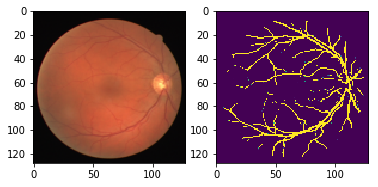

In [27]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)